In [1]:
import os

PROJECT_PATH = "/home/lixy/workspace/SkipLM"

In [36]:
import numpy as np
import os
import matplotlib.pyplot as plt
from datasets import load_dataset


def compare_code_difference_line_wise(original_code, modified_code):
    """
    Compare two pieces of code line by line using dynamic programming and report the fraction of differences.
    
    Args:
        original_code (str): The original code as a string
        modified_code (str): The modified code as a string
        
    Returns:
        float: Fraction of lines that differ (0.0 to 1.0)
        list: List of line numbers (0-indexed) that differ
    """
    # Split both code snippets into lines
    original_lines = original_code.splitlines()
    modified_lines = modified_code.splitlines()
    
    # If either code snippet is empty, handle appropriately
    if not original_lines and not modified_lines:
        return 0.0, []
    if not original_lines:
        return 1.0, list(range(len(modified_lines)))
    if not modified_lines:
        return 1.0, list(range(len(original_lines)))
    
    # Initialize the DP table for Longest Common Subsequence (LCS)
    dp = [[0 for _ in range(len(modified_lines) + 1)] for _ in range(len(original_lines) + 1)]
    
    # Fill the DP table
    for i in range(1, len(original_lines) + 1):
        for j in range(1, len(modified_lines) + 1):
            if original_lines[i-1] == modified_lines[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
            else:
                dp[i][j] = max(dp[i-1][j], dp[i][j-1])
    
    # Backtrack to find differences
    different_lines = []
    i, j = len(original_lines), len(modified_lines)
    
    # Track the matching lines to determine which ones differ
    matching_pairs = []
    
    while i > 0 and j > 0:
        if original_lines[i-1] == modified_lines[j-1]:
            matching_pairs.append((i-1, j-1))
            i -= 1
            j -= 1
        elif dp[i-1][j] > dp[i][j-1]:
            i -= 1
        else:
            j -= 1
    
    # Determine which lines in both files are different
    original_matched = set(p[0] for p in matching_pairs)
    modified_matched = set(p[1] for p in matching_pairs)
    
    # Lines from original that weren't matched
    for i in range(len(original_lines)):
        if i not in original_matched:
            different_lines.append(i)
    
    # Lines from modified that weren't matched
    for j in range(len(modified_lines)):
        if j not in modified_matched:
            # Find the insertion point in the original file
            insertion_point = next((i for i, (oi, _) in enumerate(sorted(matching_pairs)) if oi > j), len(original_lines))
            if insertion_point not in different_lines:
                different_lines.append(insertion_point)
    
    # Sort different lines for clearer output
    different_lines.sort()
    
    # Calculate fraction of differences
    # max_lines = max(len(original_lines), len(modified_lines))
    # difference_fraction = len(different_lines) / max_lines if max_lines > 0 else 0.0
    difference_fraction = 1 - (len(original_matched) / len(original_lines))
    
    return difference_fraction, different_lines


def show_diffs_line_wise(json_path: str):
    """
    Analyze code differences and visualize distributions.
    
    Args:
        json_path (str): Path to the JSON file containing code samples
        project_path (str): Base path of the project
    """
    # Load the dataset
    dataset = load_dataset("json", data_files=[os.path.join(PROJECT_PATH, json_path)], split="train")
    
    def map_func(example):
        original = example["code"]
        modified = example["modified_code"]
        frac, different_lines = compare_code_difference_line_wise(original, modified)
        return {
            "diff_fraction": frac,
            "num_diff_lines": len(different_lines)
        }

    # Process the dataset
    dataset = dataset.map(map_func, num_proc=128)
    
    # Convert to pandas for easier plotting
    df = dataset.to_pandas()
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    

    frac_bins = 100
    
    ax1.hist(df["diff_fraction"], bins=frac_bins)
    ax1.set_title("Distribution of Difference Fractions")
    ax1.set_xlabel("Fraction of Different Lines")
    ax1.set_ylabel("Frequency")

    
    # 2. Plot the distribution of number of different lines
    # Determine appropriate bins for the number of lines
    # max_diff_lines = df["num_diff_lines"].max()
    max_diff_lines = np.percentile(df["num_diff_lines"], 99)
    if max_diff_lines <= 20:
        # If the max is small, use integer bins
        line_bins = np.arange(0, max_diff_lines + 2)
    else:
        # Otherwise, create reasonable bins (about 20 bins)
        line_bins = np.linspace(0, max_diff_lines + (max_diff_lines / 20), 21)
    
    # Plot histogram directly
    ax2.hist(df["num_diff_lines"], bins=line_bins)
    ax2.set_title("Distribution of Number of Different Lines")
    ax2.set_xlabel("Number of Different Lines")
    ax2.set_ylabel("Frequency")
    
    # Set reasonable ticks based on the range
    if max_diff_lines <= 20:
        ax2.set_xticks(np.arange(0, max_diff_lines + 2, 2))
    else:
        # Create about 5-6 ticks
        step = max(1, int(max_diff_lines / 5))
        ax2.set_xticks(np.arange(0, max_diff_lines + step, step))
    
    # Add overall title and adjust layout
    plt.suptitle("Code Difference Analysis", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save the figure
    plt.savefig("code_diff_distribution.png", dpi=300, bbox_inches="tight")
    
    # Show the figure
    plt.show()
    
    # Print some statistics
    print(f"Total samples analyzed: {len(df)}")
    print(f"Average difference fraction: {df['diff_fraction'].mean():.4f}")
    print(f"Median difference fraction: {df['diff_fraction'].median():.4f}")
    print(f"Average number of different lines: {df['num_diff_lines'].mean():.2f}")
    print(f"Median number of different lines: {df['num_diff_lines'].median():.2f}")
    

Map (num_proc=128):   0%|                                                                                     …

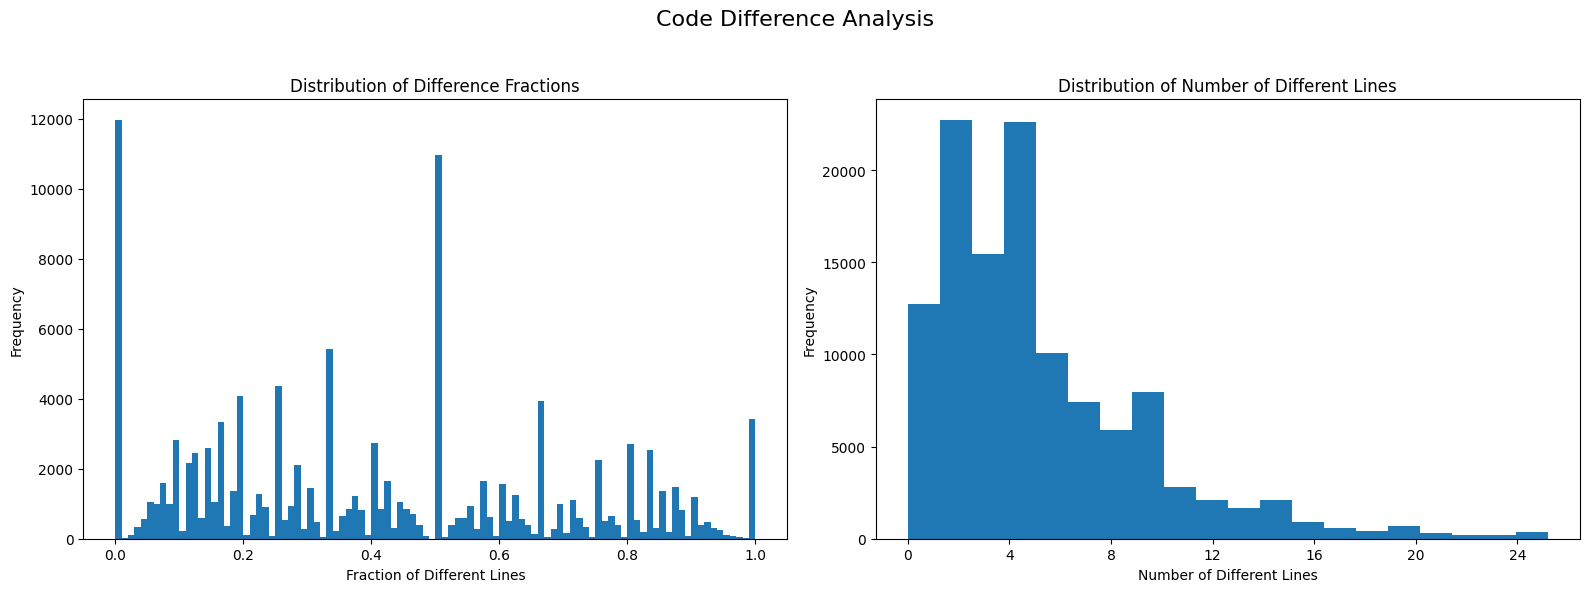

Total samples analyzed: 118278
Average difference fraction: 0.4039
Median difference fraction: 0.3750
Average number of different lines: 5.52
Median number of different lines: 4.00


In [37]:
show_diffs_line_wise("outputs/opc-sft-stage2/education_qwen72b.json")

Map (num_proc=128):   0%|                                                                                     …

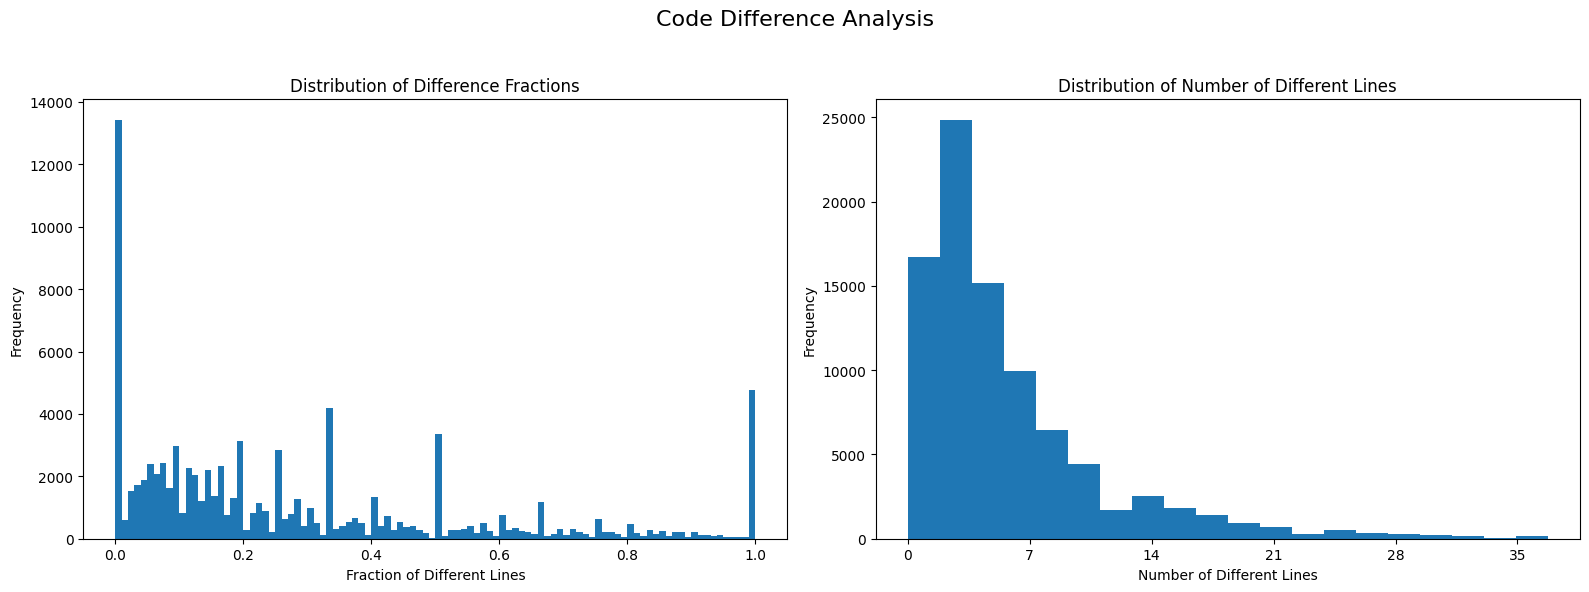

Total samples analyzed: 89494
Average difference fraction: 0.2804
Median difference fraction: 0.1875
Average number of different lines: 6.12
Median number of different lines: 4.00


In [38]:
show_diffs_line_wise("outputs/opc-sft-stage2/evol_qwen72b.json")

Map (num_proc=128):   0%|                                                                                     …

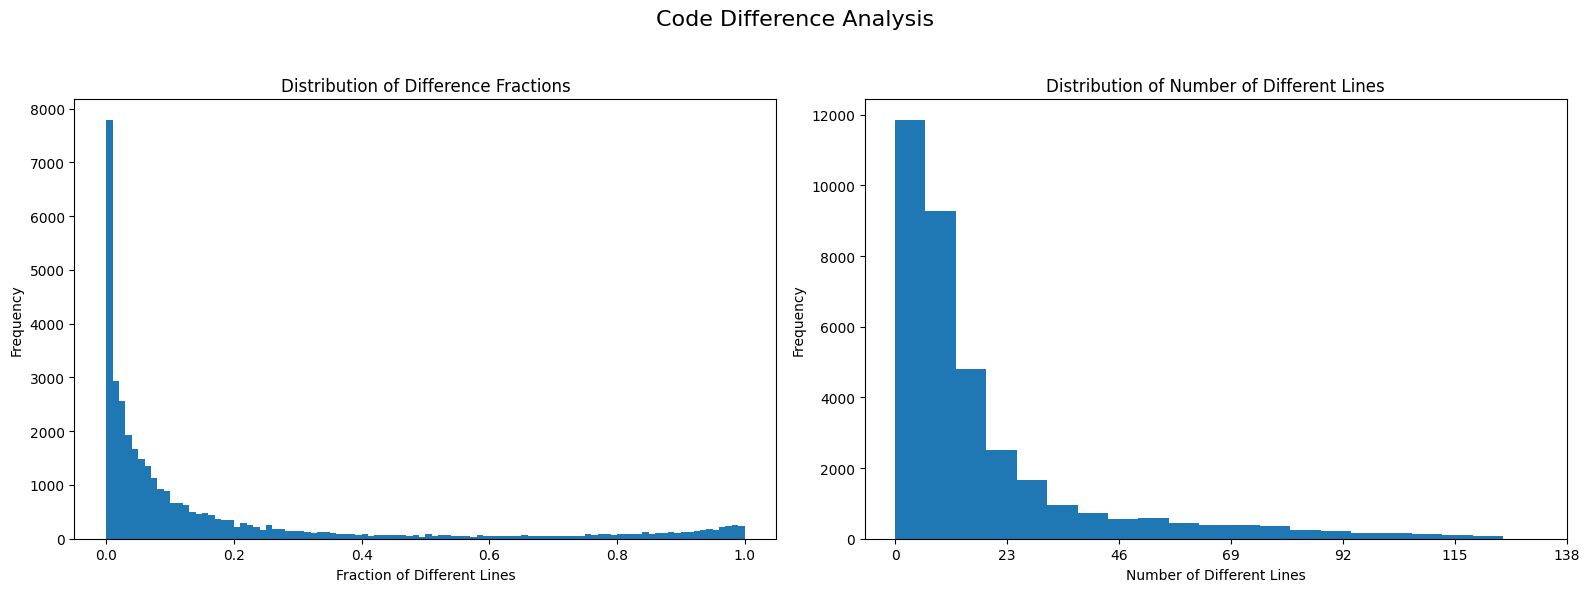

Total samples analyzed: 35821
Average difference fraction: 0.1748
Median difference fraction: 0.0566
Average number of different lines: 18.83
Median number of different lines: 10.00


In [39]:
show_diffs_line_wise("outputs/opc-sft-stage2/mceval_qwen72b.json")

Map (num_proc=128):   0%|                                                                                     …

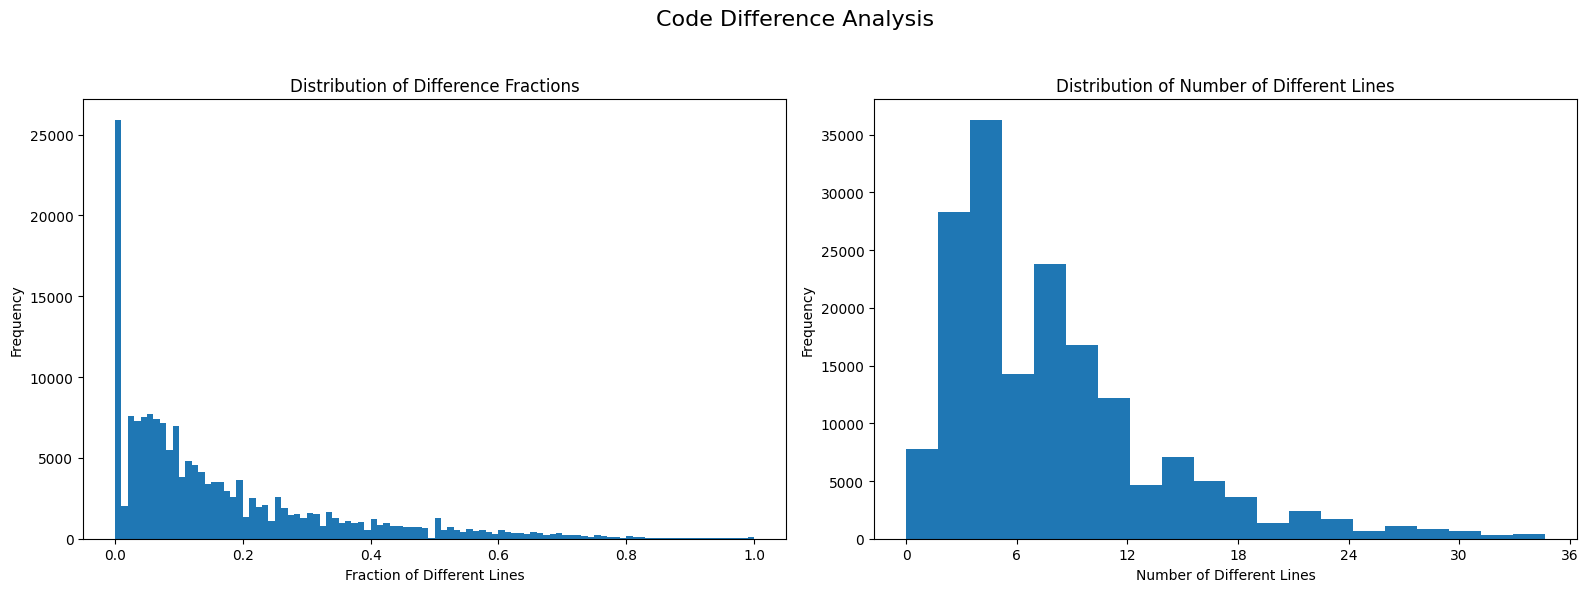

Total samples analyzed: 170778
Average difference fraction: 0.1636
Median difference fraction: 0.1026
Average number of different lines: 8.30
Median number of different lines: 6.00


In [40]:
show_diffs_line_wise("outputs/opc-sft-stage2/package_qwen72b.json")

In [46]:
import numpy as np
import os
import matplotlib.pyplot as plt
from datasets import load_dataset


def compare_code_difference_line_wise(original_code, modified_code):
    """
    Compare two pieces of code line by line using dynamic programming and report the fraction of differences.
    
    Args:
        original_code (str): The original code as a string
        modified_code (str): The modified code as a string
        
    Returns:
        float: Fraction of lines that differ (0.0 to 1.0)
        list: List of line numbers (0-indexed) that differ
        int: Total number of lines in original code
        int: Number of lines in original code that weren't matched
    """
    # Split both code snippets into lines
    original_lines = original_code.splitlines()
    modified_lines = modified_code.splitlines()
    
    # Get the total number of lines in original code
    total_original_lines = len(original_lines)
    
    # If either code snippet is empty, handle appropriately
    if not original_lines and not modified_lines:
        return 0.0, [], 0, 0
    if not original_lines:
        return 1.0, list(range(len(modified_lines))), 0, 0
    if not modified_lines:
        return 1.0, list(range(len(original_lines))), total_original_lines, total_original_lines
    
    # Initialize the DP table for Longest Common Subsequence (LCS)
    dp = [[0 for _ in range(len(modified_lines) + 1)] for _ in range(len(original_lines) + 1)]
    
    # Fill the DP table
    for i in range(1, len(original_lines) + 1):
        for j in range(1, len(modified_lines) + 1):
            if original_lines[i-1] == modified_lines[j-1]:
                dp[i][j] = dp[i-1][j-1] + 1
            else:
                dp[i][j] = max(dp[i-1][j], dp[i][j-1])
    
    # Backtrack to find differences
    different_lines = []
    i, j = len(original_lines), len(modified_lines)
    
    # Track the matching lines to determine which ones differ
    matching_pairs = []
    
    while i > 0 and j > 0:
        if original_lines[i-1] == modified_lines[j-1]:
            matching_pairs.append((i-1, j-1))
            i -= 1
            j -= 1
        elif dp[i-1][j] > dp[i][j-1]:
            i -= 1
        else:
            j -= 1
    
    # Determine which lines in both files are different
    original_matched = set(p[0] for p in matching_pairs)
    modified_matched = set(p[1] for p in matching_pairs)
    
    # Lines from original that weren't matched
    unmatched_original_lines = []
    for i in range(len(original_lines)):
        if i not in original_matched:
            different_lines.append(i)
            unmatched_original_lines.append(i)
    
    # Lines from modified that weren't matched
    for j in range(len(modified_lines)):
        if j not in modified_matched:
            # Find the insertion point in the original file
            insertion_point = next((i for i, (oi, _) in enumerate(sorted(matching_pairs)) if oi > j), len(original_lines))
            if insertion_point not in different_lines:
                different_lines.append(insertion_point)
    
    # Sort different lines for clearer output
    different_lines.sort()
    
    # Calculate fraction of differences
    difference_fraction = 1 - (len(original_matched) / len(original_lines))
    
    # Number of unmatched lines in original code
    num_unmatched_original = len(unmatched_original_lines)
    
    return difference_fraction, different_lines, total_original_lines, num_unmatched_original


def show_code_scatterplot(json_path: str):
    """
    Analyze code differences and create a scatter plot showing:
    x-axis: number of lines in original code
    y-axis: number of lines not matched in original code
    
    Args:
        json_path (str): Path to the JSON file containing code samples
        project_path (str): Base path of the project
    """
    # Load the dataset
    dataset = load_dataset("json", data_files=[os.path.join(PROJECT_PATH, json_path)], split="train")
    
    def map_func(example):
        original = example["code"]
        modified = example["modified_code"]
        frac, different_lines, total_original_lines, unmatched_original_lines = compare_code_difference_line_wise(original, modified)
        return {
            "diff_fraction": frac,
            "num_diff_lines": len(different_lines),
            "total_original_lines": total_original_lines,
            "unmatched_original_lines": unmatched_original_lines
        }

    # Process the dataset
    dataset = dataset.map(map_func, num_proc=128)
    
    # Convert to pandas for plotting
    df = dataset.to_pandas()
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot with alpha for better visualization of overlapping points
    plt.scatter(df["total_original_lines"], df["unmatched_original_lines"], 
                alpha=0.3, s=10, c='blue', edgecolors='none')
    
    # Add a reference line y=x (maximum possible unmatched lines)
    max_lines = max(df["total_original_lines"].max(), df["unmatched_original_lines"].max())
    plt.plot([0, max_lines], [0, max_lines], 'r--', alpha=0.5, label='y=x (100% unmatched)')
    
    # Add labels and title
    plt.xlabel('Number of Lines in Original Code')
    plt.ylabel('Number of Lines Not Matched in Original Code')
    plt.title('Relationship Between Code Size and Unmatched Lines')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Ensure axes start at 0
    plt.xlim(0, max_lines * 1.05)
    plt.ylim(0, max_lines * 1.05)
    
    # Add colorbar for density visualization (optional)
    # norm = plt.Normalize(0, df["diff_fraction"].max())
    # sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    # sm.set_array([])
    # plt.colorbar(sm, label="Difference Fraction")
    
    # Save the figure
    plt.tight_layout()
    plt.savefig("code_lines_scatter.png", dpi=300, bbox_inches="tight")
    
    # Show the figure
    plt.show()
    
    # Print some statistics
    print(f"Total samples analyzed: {len(df)}")
    print(f"Average original code lines: {df['total_original_lines'].mean():.2f}")
    print(f"Average unmatched lines: {df['unmatched_original_lines'].mean():.2f}")
    print(f"Correlation coefficient: {df['total_original_lines'].corr(df['unmatched_original_lines']):.4f}")

# Example usage
# PROJECT_PATH = "/path/to/your/project"
# show_code_scatterplot("your_data.json", PROJECT_PATH)

Map (num_proc=128):   0%|                                                                                     …

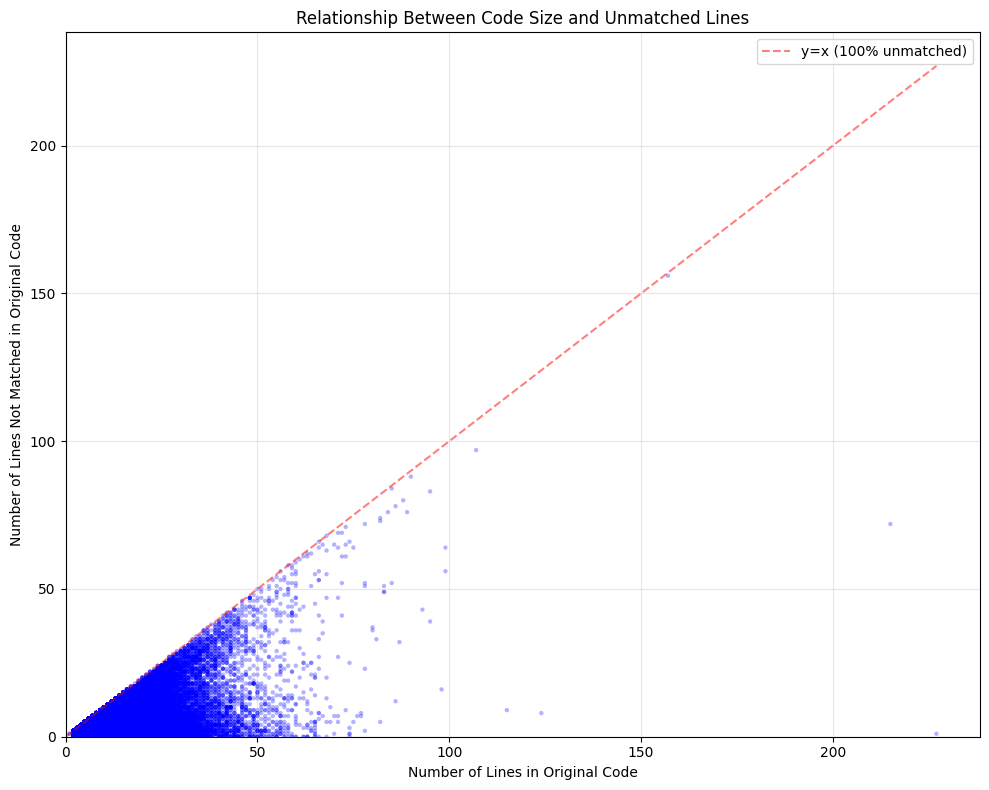

Total samples analyzed: 118278
Average original code lines: 11.09
Average unmatched lines: 4.25
Correlation coefficient: 0.5908


In [47]:
show_code_scatterplot("outputs/opc-sft-stage2/education_qwen72b.json")

Map (num_proc=128):   0%|                                                                                     …

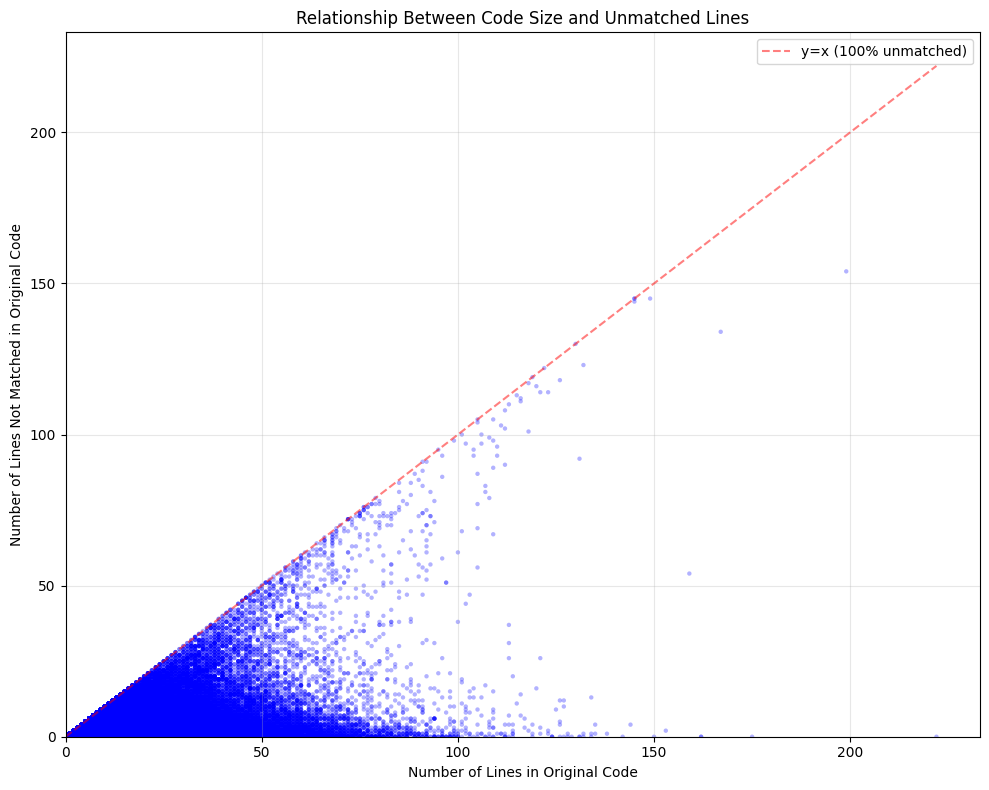

Total samples analyzed: 89494
Average original code lines: 19.37
Average unmatched lines: 4.34
Correlation coefficient: 0.4106


In [48]:
show_code_scatterplot("outputs/opc-sft-stage2/evol_qwen72b.json")

Map (num_proc=128):   0%|                                                                                     …

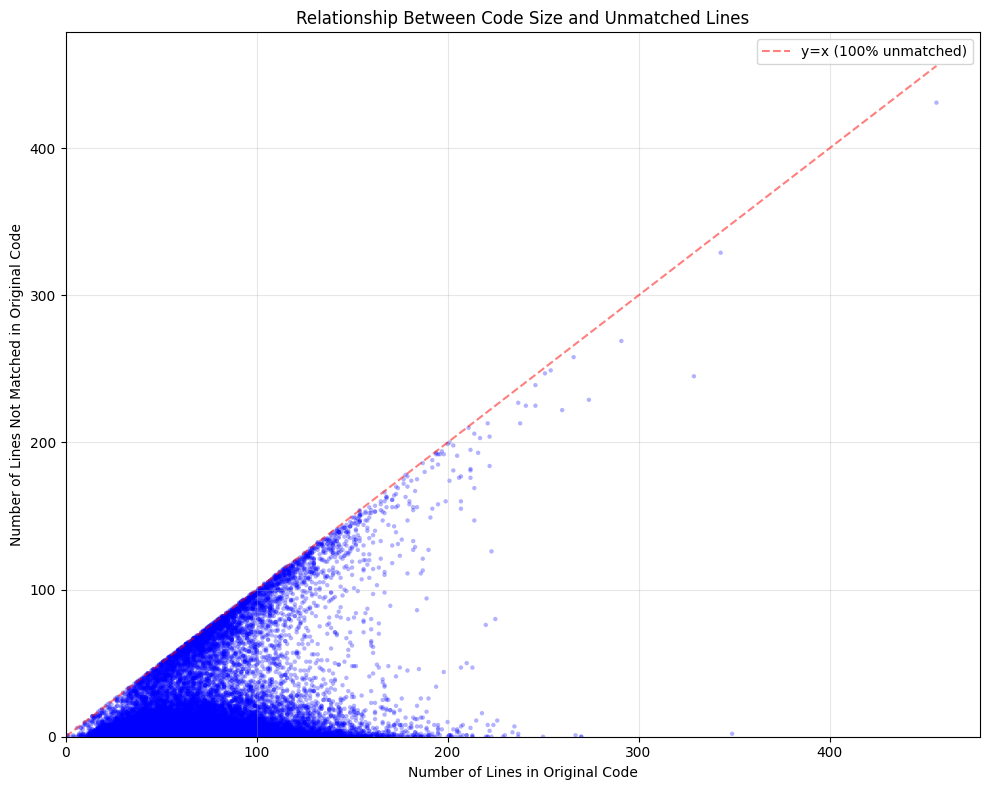

Total samples analyzed: 35821
Average original code lines: 68.20
Average unmatched lines: 12.99
Correlation coefficient: 0.3757


In [49]:
show_code_scatterplot("outputs/opc-sft-stage2/mceval_qwen72b.json")

Map (num_proc=128):   0%|                                                                                     …

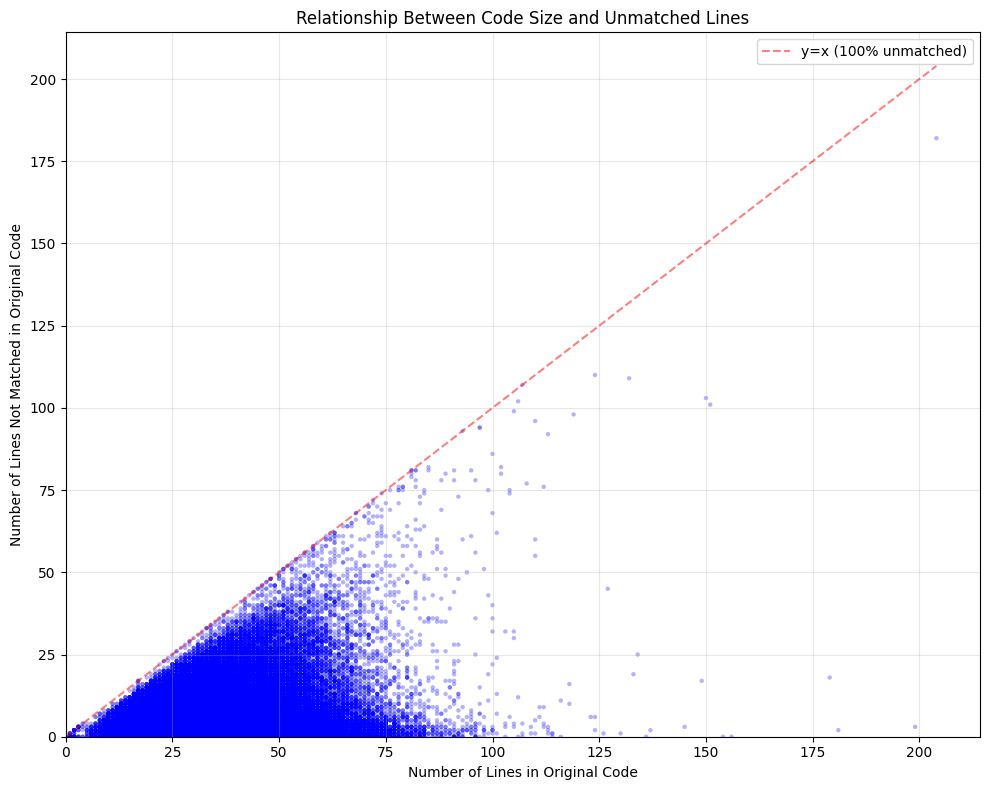

Total samples analyzed: 170778
Average original code lines: 33.72
Average unmatched lines: 5.31
Correlation coefficient: 0.2454


In [50]:
show_code_scatterplot("outputs/opc-sft-stage2/package_qwen72b.json")